In [1]:
import numpy as np  # 추가된 부분
import gymnasium as gym
from gymnasium.spaces import MultiBinary
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import configure

# 스마트 팩토리 환경 생성
class SmartFactoryEnv(gym.Env):
    def __init__(self, n_machines=5, energy_limit=10):
        super(SmartFactoryEnv, self).__init__()
        self.n_machines = n_machines
        self.energy_limit = energy_limit

        # Multi-Binary 행동 공간
        self.action_space = MultiBinary(n_machines)

        # 관찰 공간
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(n_machines + 1,), dtype=float
        )

        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.zeros(self.n_machines + 1, dtype=float)
        return self.state, {}

    def step(self, action):
        energy_usage = np.dot(np.random.uniform(1, 2, self.n_machines), action)
        production = np.dot(np.random.uniform(1, 3, self.n_machines), action)
        penalty = max(0, energy_usage - self.energy_limit)
        reward = production - energy_usage - penalty

        self.state = np.concatenate([action, [energy_usage]])

        done = energy_usage > self.energy_limit * 2
        return self.state, reward, done, False, {}

    def render(self):
        print(f"Machines: {self.state[:-1]}, Energy Usage: {self.state[-1]}")

# 환경 생성 및 래핑
env = DummyVecEnv([lambda: SmartFactoryEnv(n_machines=5, energy_limit=10)])

# 로그 저장 디렉토리 설정
log_dir = "./logs/"
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])

# PPO 모델 생성
model = PPO("MlpPolicy", env, verbose=1)
model.set_logger(new_logger)

# 학습
model.learn(total_timesteps=100000)


Logging to ./logs/
Using cuda device


/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1381 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 959         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010395495 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.46       |
|    explained_variance   | -0.000141   |
|    learning_rate        | 0.0003      |
|    loss                 | 45.1        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 212         |
-----------------------------------------
----------------------------------

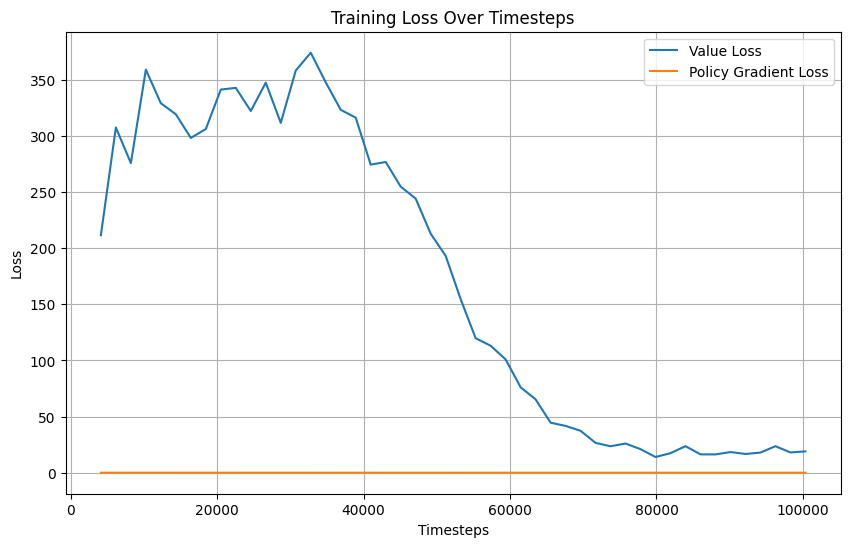

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 로그 파일 경로
log_csv_path = "./logs/progress.csv"

# CSV 파일 읽기
data = pd.read_csv(log_csv_path)

# 주요 메트릭 시각화
plt.figure(figsize=(10, 6))

# 학습 손실 시각화
plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss")
plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss")

# 그래프 레이블 설정
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("Training Loss Over Timesteps")
plt.legend()
plt.grid()
plt.show()

In [3]:
from stable_baselines3.common.evaluation import evaluate_policy

# 학습된 모델 평가
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# 보상 시뮬레이션
rewards = []
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        obs = env.reset()

# 보상 시각화
plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Rewards Over Steps")
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# 학습된 모델 평가
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)

print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
